# 如何成为一部成功的商业电影

本文从电影🎬六大相关信息（题材、上映时间、评价、成本预算、导演、主演）入手，探索对于一部商业电影来说，哪些要素对其盈利性有着重要作用。同时，绘制了各类有趣的图表，包括wordcloud、泡泡图、Network Graph、折线图、柱状图等等。 

在以下操作中，我们用到的原数据集时间跨度为1910年至2016年，但在具体分析中，也按需有所取舍，比如在1.1中想了解最近市场上什么样子的电影居多，我们只挑选了1990年往后近30年的数据作为参考。    

*R.I.P 斯坦李*       

*发表于[和鲸社区](https://www.kesci.com/home/project/5beadfe0954d6e001063e85b)*

## 目录
### 一、数据清洗**🌧
### 二、可视化分析**📈  
#### 1. 什么题材好赚钱？**💰   
##### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;1.1 市场上各类影片的分布情况（Wordcloud）    
##### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;1.2 不同题材的收益变化（折线图）      
#### 2. "天时"对一部电影重不重要🧐（上映时间）      
##### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.1 月份的讲究（热力图）        
##### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.2 星期的讲究（柱状图）       
#### 3. 观众爸爸们越来越重要❗️          
##### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.1 投票数量的变化趋势（柱状图）            
##### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;3.2 不同年代观众评价的变化（柱状图）          
#### 4. 花的越多，片子就越好吗❓（泡泡图）          
#### 5. 导演拍得越多，赚得越多吗🤔（附下拉选择框的条形图）     
#### 6. 当红炸子鸡效应（主演）💥    
##### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;6.1 主演们的合作联系情况（Network Graph)     
##### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;6.2 当红炸子鸡们出演电影的平均表现对比（附下拉选择框的条形图）     

# 一、数据清洗

#### 数据清洗这一步骤，是为了后续的可视化做准备。
#### 我们将需要使用的对象提取出来，e.g.计算利润、拆分年月日、提取主演们、提取影片的导演等等；
#### 删除多余的字段，e.g.电影的ID；
#### 删除缺失值较多的字段，e.g.主页homepage。
#### ------✨------✨------✨------✨------

In [1]:
#导入模块
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:

movie_df = pd.read_csv('tmdb_5000_movies.csv')
credits_df = pd.read_csv("tmdb_5000_credits.csv")
combine = pd.merge(movie_df, credits_df, left_on = 'id', right_on = 'movie_id')
del combine['title_y']
combine.rename(columns={'title_x':'title'},inplace=True)

#解读带中括号的那些复杂字段
def process_df(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    json_cols = ['genres', 'keywords', 'production_countries', \
                 'production_companies', 'spoken_languages', 'cast', 'crew']
    for col in json_cols:
        df[col] = df[col].apply(json.loads)
    return df

combined_df = process_df(combine)

查看处理完毕后的数据，以前两条为例

In [3]:
combined_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."


In [4]:
def name_2_list(cols):
    """
    Converts columns that have values in the name column to a list and returns it.
    :param: cols is a column you wish to process
    :return: a list with the column values that have a key of "name"
    """
    lst = []
    for co in cols:
        lst.append(co['name'])
    return lst

In [5]:
for col in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
    combined_df[col] = combined_df[col].apply(name_2_list)

#处理缺失值
combined_df.isnull().sum(axis=0).reset_index()
del combined_df["tagline"], combined_df["homepage"]
combined_df.dropna(inplace=True)

In [6]:
#将每部影片的前三位演员提取出来，分别放入actor1,actor2和actor3三列中
def get_actor(x, actor_num):
    for item in x:
        if item["order"] == actor_num: 
            return item["name"]
combined_df['actor1'] = combined_df['cast'].apply(get_actor, actor_num=0)
combined_df['actor2'] = combined_df['cast'].apply(get_actor, actor_num=1)
combined_df['actor3'] = combined_df['cast'].apply(get_actor, actor_num=2)

In [7]:
#从crew中提取导演姓名，放入director列中
def get_director(x):
    for item in x:
        if item["job"] == 'Director': 
            return item["name"]
combined_df['director'] = combined_df['crew'].apply(get_director)

In [8]:
#只保留已发布的电影，删除多余字段
combined_df = combined_df[combined_df['status'] == 'Released']
del combined_df['status'], combined_df['original_title']
del combined_df['movie_id'], combined_df['id']

In [9]:
#从<发布时间>该字段提取影片发布的年月日以及星期
combined_df["year"] = combined_df.release_date.dt.year
combined_df["month"] = combined_df.release_date.dt.month
combined_df["day"] = combined_df.release_date.dt.day
combined_df["dow"] = combined_df.release_date.dt.dayofweek
#我们需要的是数据截止2016年。由于拉取数据时间的缘故，可能混入2017年初的电影数据，因此在此做排除。
combined_df = combined_df[combined_df["year"] != 2017]

In [10]:
#清洗过的数据保存为cleaned_data，以备后续使用
combined_df.to_csv("cleaned_data.csv", index = None)

# 二、可视化分析

In [11]:
import pandas as pd
import numpy as np
#plotly作图
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
py.offline.init_notebook_mode(connected=True)
from math import floor
from plotly import tools
from plotly.graph_objs import *
#from IPython.display import display
from plotly.widgets import GraphWidget
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
#bokeh作图
from bokeh.plotting import figure, output_file, show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker, LogTicker, ContinuousTicker, AdaptiveTicker,
    PrintfTickFormatter,
    ColorBar,
    FactorRange)
import bokeh.palettes
from bokeh.transform import factor_cmap
from wordcloud import WordCloud, STOPWORDS
from math import floor
from bokeh.io import output_notebook
from bokeh.models import NumeralTickFormatter
from bokeh.resources import CDN
from bokeh.embed import file_html
%config InlineBackend.figure_format = 'retina'
output_notebook()

<IPython.core.display.Javascript object>

Loading BokehJS ...

In [12]:
data = pd.read_csv("cleaned_data.csv")

加入新字段profit，根据“收入-预算”计算
电影利润的均值约为53,364,000，记录中盈利状况最好的影片为Avatar，利润达2,550,965,000

In [13]:
data["profit"] = data["revenue"] - data["budget"]
data["profit"].describe()

count    4.790000e+03
mean     5.336400e+07
std      1.361221e+08
min     -1.657101e+08
25%     -7.985852e+05
50%      2.602056e+06
75%      5.546026e+07
max      2.550965e+09
Name: profit, dtype: float64

# 1. 什么题材好赚钱？💰 

In [14]:
df1 = pd.concat([pd.Series(row['year'], row['genres'].replace('[','').replace(']','').replace("'","").split(','))              
                    for _, row in data[data["year"]>1990][["year","genres"]].iterrows()]).reset_index()
df2 = pd.concat([pd.Series(row['profit'], row['genres'].replace('[','').replace(']','').replace("'","").split(','))              
                    for _, row in data[data["year"]>1990][["profit","genres"]].iterrows()]).reset_index()

In [15]:
df1.columns = ["genres","year"]
df2.columns = ["genres","profit"]

In [16]:
df1["profit"] = df2["profit"]
df1["genres"] = df1["genres"].apply(lambda x: x.strip())
del df2

#### Q：现在市场上都是些什么电影呢？
#### A：如今，喜剧类、惊悚类、动作类、冒险类、爱情类都是几种主打的电影题材。

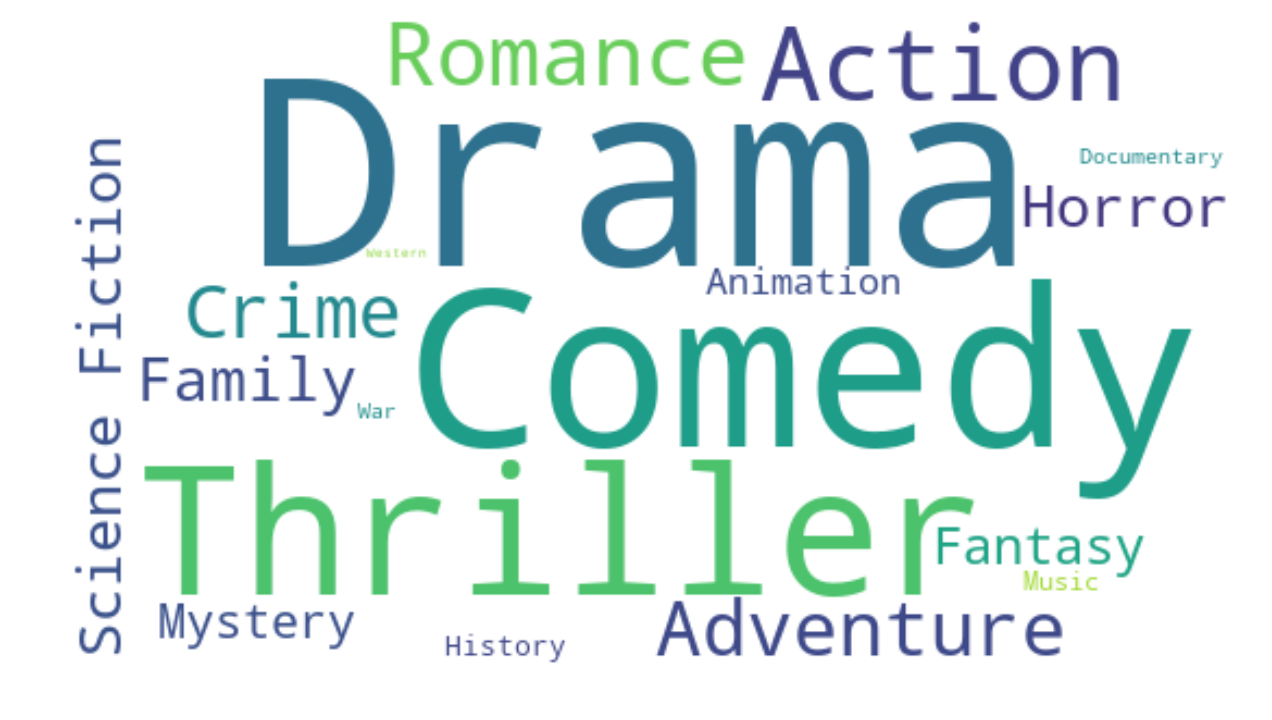

In [17]:
words = dict()
trunc_occurences = df1.groupby(["genres"]).size().sort_values(ascending=False).reset_index()
trunc_occurences.columns = ["genres", "frequency"]
for i in range(18):
    words[trunc_occurences["genres"][i]] = trunc_occurences["frequency"][i]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### 1.2 不同题材的收益变化（折线图）   


挑选一些出现频率较多，也较为常见的题材，观察它们从90年代开始平均收益额的变化情况。
- 虽然市场上的影片喜剧、戏剧居多，但是它们的盈利表现并不出众，一直都较为平稳。
- 相反家庭题材、冒险类以及动作题材的电影，盈利性都很突出。
- 特别是，2014年后，家庭题材电影的收益呈现了直线上升的趋势，突破平均2.5亿的利润额。

In [18]:
genres = ["Drama","Comedy","Thriller","Action","Adventure","Crime","Science", "Fiction","Family"]
grouped_data = df1[df1["genres"].isin(genres)].groupby(["genres","year"]).profit.mean().reset_index()

In [19]:
dict_group_data = {"xs":[grouped_data.loc[(grouped_data["genres"]==name),"year"].values \
                         for name in grouped_data['genres'].unique()],
                  "ys": [grouped_data.loc[(grouped_data["genres"]==name),"profit"].values\
                         for name in grouped_data['genres'].unique()],
                  "labels": grouped_data["genres"].unique(),
                  "color": bokeh.palettes.Category10[7]}

source = ColumnDataSource(dict_group_data)

hover = HoverTool(tooltips=[
    ("Genre", "@labels"),
])

p = figure(x_axis_label = 'Year', 
           y_axis_label = 'Profit', 
           width = 1000,
           tools=[hover, "save","pan","box_zoom","reset","wheel_zoom"]) 
p.yaxis[0].formatter = NumeralTickFormatter(format="$,")

p.multi_line(xs= "xs", ys= "ys", line_color= "color", source = source, legend = "labels",line_width=3)
p.legend.location = "top_left"

p.title.text = "Profit for each Genre across years"
p.title.align = "center"
p.title.text_font_size = "20px"

show(p)

# 2."天时"对一部电影重不重要🧐（上映时间）   


### 2.1 月份的讲究（热力图）
1990年-2016年不同月份上映影片的平均收益额概览图。   
从图中我们可以发现，在每年年初、年末上映的影片（e.g.二月，六月，七月，十一月，十二月），相对会获得比较好的收益。

In [20]:
profit_by_month_year = data[data["year"]>1990].groupby(["year","month"]).profit.mean().reset_index()
count_by_month_year = data[data["year"]>1990].groupby(["year","month"]).size().reset_index()

In [21]:
newdata = ColumnDataSource(profit_by_month_year)

mapper = LinearColorMapper(palette=bokeh.palettes.RdBu[9], 
                           low=profit_by_month_year["profit"].min(), high=profit_by_month_year["profit"].max())


hover = HoverTool(
    tooltips=[
        ("profit", "@profit{$,}"),
    ]
)    

TOOLS = [hover,"save,pan,box_zoom,reset,wheel_zoom"]


p = figure(x_axis_label = 'Year', 
           y_axis_label = 'Month',
           tools=TOOLS,
           plot_width = 900)

p.rect(x="year", y="month",width=1, height=1,source = newdata,
       fill_color={'field': 'profit', 'transform': mapper})

color_bar = ColorBar(color_mapper=mapper, location=(20, 0), label_standoff=18,
                     ticker= AdaptiveTicker(), formatter = NumeralTickFormatter(format="$,") )

p.add_layout(color_bar, 'right')

p.title.text = "Movie Profit by Year and Month"
p.title.align = "center"
p.title.text_font_size = "20px"

show(p)

### 2.2 星期的讲究（柱状图）


#### Q：在星期几上映的电影，往往容易获得高收益呢？
#### A：星期二，星期一与星期日为Top3，远高于休息日星期六。

In [22]:
profit_by_dow = data.groupby(["dow"]).profit.mean().reset_index()

In [23]:
import colorlover as cl
bar_data = [go.Bar(x=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']\
                   , y=profit_by_dow["profit"],marker=dict(color = cl.scales['7']['div']['RdYlGn']))]

py.offline.iplot({ 'data': bar_data,
            'layout': {
               'title': 'Average Profit by Days of Week',
               'xaxis': {
                 'title': 'Days of Week'},
               'yaxis': {
                'title': 'Profit'}
        }})

# 3. 观众爸爸们越来越重要❗️ 


### 3.1 投票数量的变化趋势（柱状图）
随着时代发展，互联网的普及，观众有更多的渠道发表自己对电影的见解与看法，影评总数从60年代开始攀升，到90年代增长尤为显著。 

In [24]:
def extract_decade(x):
    return str(floor(x/10)*10)+"s"
data["decade"] = data["year"].apply(extract_decade)
df = data
df = df.sort_values(by=['decade'], ascending=True)

In [25]:
df_by_vote = df.groupby(['decade']).vote_count.sum().reset_index()

In [26]:
bar_data = [go.Bar(x=df_by_vote['decade']\
                   , y=df_by_vote["vote_count"],
                     marker=dict(
                        color='rgb(127,188,65)'
                    ))]

py.offline.iplot({ 'data': bar_data,
            'layout': {
               'title': 'Vote Count for each Decade',
               'xaxis': {
                 'title': 'Decade'},
               'yaxis': {
                'title': 'Total Votes'}
        }})

### 3.2 不同年代观众评价的变化（violin图） 


下图展示了不同年代影评的情况。
- 20年代之后，很长一段时间没有过高分电影；直到90年代，20世纪又开始出现评价极好的电影。
- 80年代之前，评分区间也较为集中；80年代开始，随着电影产出量的增加，影片层次不齐，低分影片开始出现，平均分也有略微下降，看来人们对影片的要求也越来越高。

In [27]:
da = []
for i in range(0,len(pd.unique(df['decade']))):
    trace = {
            "type": 'violin',
            "x": df['decade'][df['decade'] == pd.unique(df['decade'])[i]],
            "y": df['vote_average'][df['decade'] == pd.unique(df['decade'])[i]],
            "name": pd.unique(df['decade'])[i],
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        }
    da.append(trace)

        
fig = {
    "data": da,
    "layout" : {
        "title": "Average Movie Ratings by Decade",
            "xaxis" : dict(title = 'Decade', autotick=False, showticklabels=True),
            "yaxis" : dict(title = 'Average Rating')
    }
}

iplot(fig, validate = False)

# 4. 花的越多，片子就越好吗❓（泡泡图）    


下面的可视化操作将利润、预算、评分都融入进同一张图。  
成本预算高，意味着有条件将电影做得好。  
从图中可以看出，收益超过10亿的影片，投入基本在150million以上，评价也大都在中上水平。  
但是我们发现，也有很多预算少的影片也获得了很好的评价。

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4790 entries, 4581 to 2394
Data columns (total 27 columns):
budget                  4790 non-null int64
genres                  4790 non-null object
keywords                4790 non-null object
original_language       4790 non-null object
overview                4790 non-null object
popularity              4790 non-null float64
production_companies    4790 non-null object
production_countries    4790 non-null object
release_date            4790 non-null object
revenue                 4790 non-null int64
runtime                 4790 non-null float64
spoken_languages        4790 non-null object
title                   4790 non-null object
vote_average            4790 non-null float64
vote_count              4790 non-null int64
cast                    4790 non-null object
crew                    4790 non-null object
actor1                  4575 non-null object
actor2                  4700 non-null object
actor3                  4688 non-nu

In [29]:
layout1 = go.Layout(
    title='Profit vs. Budget',
    xaxis=dict(
        title='Budget',
        gridcolor='rgb(255, 255, 255)',
        range=[0, 4e8],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Profit',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    )
)
data1 = [go.Scatter(
    x=df[df.budget>5000].budget.values, # Budget
    y=df[df.budget>5000].profit.values,  # Gross
    mode='markers',
    text= df[df.budget>5000].title.values, # Movie Titles
    marker=dict(
        size=3*(df[df.budget>5000].vote_average),
        sizeref=1.0,
        color=df[df.budget>5000].vote_average.values,
                
        colorbar=go.scatter.marker.ColorBar(title='Average Rating<br> &nbsp;' , tickvals=[0,1.5,3,5,7,8.5]),

        showscale=True,
        colorscale='Viridis'
    ))]
fig = go.Figure(data1, layout=layout1)
iplot(fig)

# 5. 导演拍得越多，赚得越多吗🤔（附下拉选择框的条形图） 


In [30]:
df = data
director_df = df.groupby('director', as_index=False)
director_df = director_df.mean()
name_counts = df['director'].value_counts().to_dict() # dictionary of director and number of rows/movies per
#name_counts

In [31]:
director_df['film_count'] = director_df['director'].map(name_counts) # match the film count to the director

In [32]:
director_df.sort_values('profit', ascending=False, inplace=True)
director_df['director+count'] = director_df['director'].map(str) + " (" + director_df['film_count'].map(str) + ")"
dir_means = director_df[['director+count',  'film_count', 'profit']]

#### Q：有经验的导演们(以5部以上作品为筛选条件），他们所拍影片的评分、平均收益情况如何呢？


In [33]:
dir_subset = director_df[director_df['film_count'] > 5]

In [34]:
top10pro = dir_subset.sort_values(ascending = False, by = 'profit')[['director+count','profit','vote_average']].head(10)
y=top10pro['director+count']

作品最多的10位导演，他们是：James Cameron, Peter Jackson, Christopher Nolan, Michael Bay, Jon Favreau, James Wan, Gore Verbinski, Sam Mendes, Chris Columbus和 Steven Spielberg。

#### A：
- 这些导演的作品数量主要在7部左右，评分也大都在7分上下浮动。仅有8部作品的Christopher Nolan均分直逼8分。
- 拍摄数量最多的导演Steve Spielberg拥有27部作品，其平均收益额却是榜上所有导演中最低的。
- 仅有7部作品的James Cameron却获得了高达733million的平均收益额，其次是Peter Jackson和Christopher Nolan。
- 这么说来，也不是拍得越多，赚得越多呀。

In [35]:
trace1 = go.Bar(y=top10pro['director+count'],
                orientation = 'h',
            x=top10pro['profit']/1000000,
            name='Profit',
            marker=dict(
            color='rgb(37,52,148)'))

trace2 = go.Bar(y=top10pro['director+count'],
            orientation = 'h',
            x=top10pro['vote_average']*10,
            name='Vote',
            marker=dict(color='rgb(161,215,106)')
                       )


updatemenus = list([
    dict(active=-1,
         x=-0.3,
         buttons=list([  
             
            dict(
                label = 'Average Profit (in Millions)',
                 method = 'update',
                 args = [{'visible': [True, False, False]}, 
                     {'title': 'Average Profit'}]),

            dict(
                 label = 'Average Vote',
                 method = 'update',
                 args = [{'visible': [False, True,False]},
                     {'title': 'Average Vote'}])
        ]),
    )
])

data7=[trace1, trace2]
layout7 = dict(title='Average Measures for Important Directors (Select from Dropdown)', showlegend=True,
              updatemenus=updatemenus)

fig = dict(data=data7, layout=layout7)

iplot(fig)

# 6. 当红炸子鸡效应（主演）💥  


### 6.1 主演们的合作联系情况（Network Graph)


一个演员可能在一部影片中出演男一号，在另一部影片中出演男二号。一般来说，主角与主角合作越多，我们认为他（她）越红。  
下图就绘制了演员与演员之间的合作情况。  
其中Robert De Niro拥有24个合作数，被认为是最活跃的一位演员。


In [36]:
df_reduced = df[['actor1', 'vote_average',
                 'year', 'title']].reset_index(drop = True)
df_appearance = df[['actor1', 'year']].groupby('actor1').count().reset_index()
most_prolific = list(df_appearance['actor1'][np.array(df_appearance['year'] > 3)])

In [37]:
subset1 = df[df.actor1.isin(most_prolific) &\
            df.actor2.isin(most_prolific) & df.actor3.isin(most_prolific)].reset_index(drop = True)
subset2 = df[df.actor1.isin(most_prolific) |\
            df.actor2.isin(most_prolific) | df.actor3.isin(most_prolific)].reset_index(drop = True)

In [38]:
pair = []
for i in range(subset1.shape[0]):
    pair.append((subset1.loc[i,"actor1"],subset1.loc[i,"actor2"]))
    pair.append((subset1.loc[i,"actor1"],subset1.loc[i,"actor3"]))
    pair.append((subset1.loc[i,"actor2"],subset1.loc[i,"actor3"]))

In [39]:
from collections import *
counter = Counter(tuple(sorted(tup)) for tup in pair)

In [40]:
edges = []
for i in range(len(counter)):
    edges.append((list(counter.keys())[i][0],list(counter.keys())[i][1],list(counter.values())[i]))
G=nx.Graph()
# G.add_weighted_edges_from(edges)
G.add_edges_from(pair)
# G.add_nodes_from(most_prolific)

In [41]:
nodes = list(G.node)
d = dict(nx.degree(G))
imp_actors = sorted(d, key=d.get)[201:]


In [42]:
pos=nx.kamada_kawai_layout(G)

In [43]:
Xv=[pos[k][0] for k in nodes]
Yv=[pos[k][1] for k in nodes]
Xed=[]
Yed=[]
for edge in edges:
    Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
    Yed+=[pos[edge[0]][1],pos[edge[1]][1], None] 

trace3=Scatter(x=Xed,
               y=Yed,
               mode='lines',
               line=go.scatter.Line(color='rgb(210,210,210)', width=1),
               hoverinfo='none'
               )  
    
trace4=Scatter(x=Xv,
               y=Yv,
               mode='markers',
               name='net',
               marker=go.scatter.Marker(symbol='circle',
                             size=10, 
               showscale=True,
               colorscale = 'Viridis',
               reversescale = False,
               color=list(d.values()),           
               colorbar=go.scatter.marker.ColorBar(title='Number of Connections<br> &nbsp;', tickvals=[2,4,6,8,10,12,14,16,18,20,22,24]),
               line=go.scatter.marker.Line(color='rgb(50,50,50)', width=0.5)
               ),
               
               text=nodes,
               hoverinfo='text'
               )
    
    

layout5=Layout(title= "Leading Actors and their Connections",  
    font= go.layout.Font(size=12),
    showlegend=False, 
    xaxis=go.layout.XAxis(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=go.layout.YAxis(showgrid=False, zeroline=False, showticklabels=False),
    margin=go.layout.Margin(
        l=40,
        r=40,
        b=85,
        t=100,
    ),         
    )

fig1=Figure([trace3,trace4], layout=layout5)
iplot(fig1)

In [44]:
features = []
for item in imp_actors:
    group = df.loc[(df['actor1'] == item) | (df['actor2']== item) ]
    features.append((item, group.profit.mean(), group.vote_average.mean(), group.popularity.mean(), d[item]))

In [45]:
top15 = pd.DataFrame(features)

### 6.2 当红炸子鸡们出演电影的平均表现对比（附下拉选择框的条形图）

下面挑选出最为活跃的15位演员，作为我们后续的分析对象。  
他们是Russell Crowe, Scarlett Johansson, Cameron Diaz, Matt Damon, Meryl Streep, Brad Pitt, Tom Cruise, Kate Winslet, Jude Law, Christian Bale, Cate Blanchett, Julianne Moore, Julia Roberts, Morgan Freeman和Robert De Niro。

In [46]:
top15.columns = ["Actor","Avg. Profit", "Avg. Vote", "Avg. Popularity", "Connections with Other Important Actors)"]


我们选取三个衡量指标：演员人气值、平均每部影片的收益额、影片的平均评分，来对比高频出境的主演们对一部影片的影响如何。   
可以在下拉菜单里面选择不同的衡量指标，条形图会产生相应变化。

In [47]:
top15['Actor1'] = top15['Actor']+ " ("+ top15['Connections with Other Important Actors)'].astype('str') + ")"

- Tom Cruise出演14部电影，平均每部电影获得了236.94million的收益额，位居榜首。与第二名Kate Winslet，第三名Christian Bale将近100million的差距。

- 这三位的人气（Popularity）也都很不错，Christian Bale和Tom Cruise分别位列人气榜第一和第二。

- 这些演员出演的电影大都表现优秀，平均评分都在6.5分左右。

- 总体来说，人气越高，出演的电影收益往往越高，电影的评分也不会差，毕竟当红炸子鸡们的有着属于自己的忠实粉丝们。



In [48]:
trace1 = go.Bar(    y=top15["Actor1"],
                        orientation = 'h',
                        x=top15["Avg. Profit"]/1000000,
                        name='Profit',
                        marker=dict(
                    color='rgb(161,215,106)'
                ))
                        

trace2 = go.Bar(y=top15["Actor1"],
                   orientation = 'h',
                    x=top15["Avg. Popularity"],
                    marker=dict(
                        color='rgb(37,52,148)'
                        #color='rgb(65,182,196)'
                    ),
                    name='Popularity')
                

trace3 = go.Bar(y=top15["Actor1"],
                   orientation = 'h',
                    x=top15["Avg. Vote"],
                    name='Vote',
                    marker=dict(
                        #color='rgb(37,52,148)'
                        color='rgb(65,182,196)'
                    )
               )


data8 = [trace1, trace2, trace3]

#set menus
updatemenus = list([
    dict(active=-1,
         x=-0.3,
         buttons=list([  
             
            dict(
                label = 'Average Profit (in Millions)',
                 method = 'update',
                 args = [{'visible': [True, False, False]}, 
                     {'title': 'Average Profit'}]),
             
             dict(
                  label = 'Average Popularity',
                 method = 'update',
                 args = [{'visible': [False, True, False]},
                     {'title': 'Average Popularity'}]),

            dict(
                 label = 'Average Vote',
                 method = 'update',
                 args = [{'visible': [False, False, True]},
                     {'title': 'Average Vote'}])
        ]),
    )
])

layout8 = dict(title='Average Measures for Important Actors (Select from Dropdown)', showlegend=False,
              updatemenus=updatemenus)

fig = dict(data=data8, layout=layout8)

iplot(fig)

Reference: 
- https://www.kaggle.com/tmdb/tmdb-movie-metadata/data
- https://towardsdatascience.com/exploring-movie-data-with-interactive-visualizations-c22e8ce5f663